In [1]:

from semiconductor_db import ConvergenceDB
db = ConvergenceDB()
print(db)
kpts=db.get("AlAs", "encut")
print(kpts)

FileNotFoundError: [Errno 2] No such file or directory: 'convergence_database.csv'

In [2]:
import pandas as pd

df = pd.read_csv("convergence_database.csv")
df.head()


,material,test_type,parameter,energy_total,energy_per_atom,path
0,AlAs,encut,E300,-9.375097,-4.687548,./convergence_tests/AlAs/conv_cutoff/E300
1,AlAs,encut,E400,-9.378425,-4.689212,./convergence_tests/AlAs/conv_cutoff/E400
2,AlAs,encut,E500,-9.378929,-4.689465,./convergence_tests/AlAs/conv_cutoff/E500
3,AlAs,encut,E600,-9.379030,-4.689515,./convergence_tests/AlAs/conv_cutoff/E600
4,AlAs,encut,E700,-9.379166,-4.689583,./convergence_tests/AlAs/conv_cutoff/E700


In [3]:
import re
import numpy as np

def get_kpt_convergence(material, per_atom=True):
    """Return a DataFrame with (N_kpoints, Energy) for k-point convergence of a material."""
    sub = df[(df["material"] == material) & (df["test_type"] == "kpt")].copy()
    if sub.empty:
        print(f"⚠️ No k-point data for {material}")
        return None

    # Extract k-grid from names like 'k8x8x8'
    def extract_grid(name):
        m = re.findall(r"k(\d+)x(\d+)x(\d+)", name)
        if m:
            return tuple(map(int, m[0]))
        return (np.nan, np.nan, np.nan)

    sub["kgrid"] = sub["parameter"].apply(extract_grid)
    sub["N_kpoints"] = sub["kgrid"].apply(lambda x: np.prod(x))
    sub = sub.sort_values("N_kpoints")

    energy_col = "energy_per_atom" if per_atom else "energy_total"
    return sub[["N_kpoints", energy_col]].reset_index(drop=True)


def get_encut_convergence(material, per_atom=True):
    """Return a DataFrame with (ENCUT, Energy) for ENCUT convergence of a material."""
    sub = df[(df["material"] == material) & (df["test_type"] == "encut")].copy()
    if sub.empty:
        print(f"⚠️ No ENCUT data for {material}")
        return None

    sub["ENCUT"] = sub["parameter"].str.extract(r"E(\d+)").astype(float)
    sub = sub.sort_values("ENCUT")

    energy_col = "energy_per_atom" if per_atom else "energy_total"
    return sub[["ENCUT", energy_col]].reset_index(drop=True)


In [5]:
kpt_df = get_kpt_convergence("AlAs")
print(kpt_df)


   N_kpoints  energy_per_atom
0         64        -4.631973
1        216        -4.684244
2        512        -4.689465
3       1000        -4.690158
4       1728        -4.690266


In [6]:
encut_df = get_encut_convergence("AlAs")
print(encut_df)


   ENCUT  energy_per_atom
0  300.0        -4.687548
1  400.0        -4.689212
2  500.0        -4.689465
3  600.0        -4.689515
4  700.0        -4.689583


In [7]:
import matplotlib.pyplot as plt

def plot_convergence(material):
    kpt = get_kpt_convergence(material)
    encut = get_encut_convergence(material)

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    if kpt is not None:
        axs[0].plot(kpt["N_kpoints"], kpt["energy_per_atom"], "-o")
        axs[0].set_xlabel("Total k-points (NkxNkyNkz)")
        axs[0].set_ylabel("Energy per atom (eV)")
        axs[0].set_title(f"{material} k-point convergence")

    if encut is not None:
        axs[1].plot(encut["ENCUT"], encut["energy_per_atom"], "-o", color="orange")
        axs[1].set_xlabel("ENCUT (eV)")
        axs[1].set_ylabel("Energy per atom (eV)")
        axs[1].set_title(f"{material} ENCUT convergence")

    plt.tight_layout()
    plt.show()


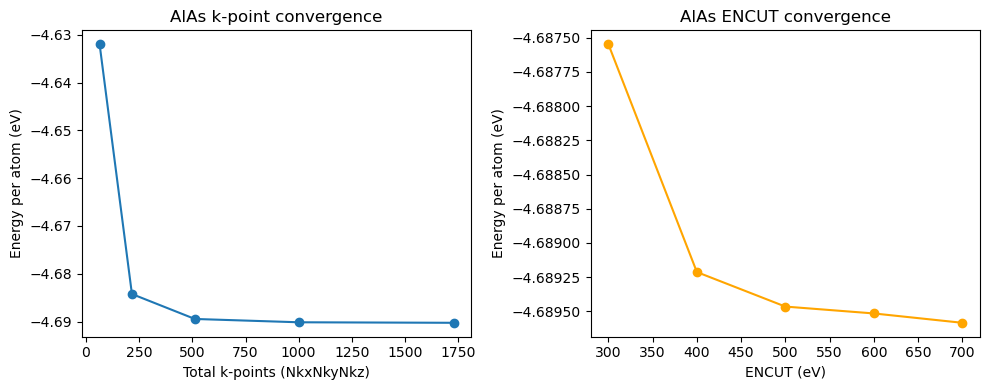

In [8]:
plot_convergence("AlAs")